In [1]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, unix_timestamp, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, to_date

In [2]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as sklearn_min_max_scaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler,  StringIndexer
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [5]:
spark = SparkSession.builder.config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").appName("predictconidtion").getOrCreate()


your 131072x1 screen size is bogus. expect trouble
24/12/12 16:09:20 WARN Utils: Your hostname, LAPTOP-DN3PCHGN resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/12 16:09:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/12 16:09:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
#
parquet_path = "/home/hoan123/project-master/weather_data_transformed2024.csv"
df = spark.read.csv(parquet_path,header=True, inferSchema=True)

In [7]:
df_sorted = df.orderBy("datetime")


In [8]:
condition_to_index = {
    "Cloudy": 0,
    "Light rain": 1,
    "Patchy rain possible": 2,
    "Moderate or heavy rain shower": 3,
    "Patchy light rain": 4,
    "Clear": 5,
    "Partly cloudy": 6,
    "Sunny": 7,
    "Patchy light drizzle": 8,
    "Light drizzle": 9,
    "Patchy light rain with thunder": 10,
    "Mist": 11,
    "Moderate rain at times": 12,
    "Thundery outbreaks possible": 13,
    "Moderate or heavy rain with thunder": 14,
    "Overcast": 15,
    "Moderate rain": 16,
    "Light rain shower": 17,
    "Heavy rain": 18,
    "Heavy rain at times": 19,
    "Fog": 20
}
#
#
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def map_condition(condition):
    return condition_to_index.get(condition, -1)  # Trả về -1 nếu không tìm thấy giá trị phù hợp

map_condition_udf = udf(map_condition, IntegerType())

#
df_sorted = df_sorted.withColumn("condition_index", map_condition_udf("condition"))

#
df_sorted.show()


+-------------------+-----+-------+--------+---------+------+--------+---------+--------------------+---------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|precip_mm|           condition|condition_index|
+-------------------+-----+-------+--------+---------+------+--------+---------+--------------------+---------------+
|2010-01-01 00:00:00|Hanoi|Vietnam| 21.0333|   105.85|  15.7|     7.3|      0.0|               Clear|              5|
|2010-01-01 01:00:00|Hanoi|Vietnam| 21.0333|   105.85|  15.8|     7.1|      0.0|              Cloudy|              0|
|2010-01-01 02:00:00|Hanoi|Vietnam| 21.0333|   105.85|  16.3|     6.8|      0.0|            Overcast|             15|
|2010-01-01 03:00:00|Hanoi|Vietnam| 21.0333|   105.85|  16.8|     6.6|      0.0|              Cloudy|              0|
|2010-01-01 04:00:00|Hanoi|Vietnam| 21.0333|   105.85|  17.3|     6.1|      0.1|   Patchy light rain|              4|
|2010-01-01 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  

In [9]:

window = Window.orderBy("datetime")

#
df_with_lags = (
    df_sorted
    .withColumn("temp_c_t-1", lag("temp_c", 1).over(window))
    .withColumn("temp_c_t-2", lag("temp_c", 2).over(window))
    .withColumn("temp_c_t-3", lag("temp_c", 3).over(window))
    .withColumn("temp_c_t-4", lag("temp_c", 4).over(window))
    .withColumn("wind_mph_t-1", lag("wind_mph", 1).over(window))
    .withColumn("wind_mph_t-2", lag("wind_mph", 2).over(window))
    .withColumn("wind_mph_t-3", lag("wind_mph", 3).over(window))
    .withColumn("wind_mph_t-4", lag("wind_mph", 4).over(window))
    .withColumn("precip_mm_t-1", lag("precip_mm", 1).over(window))
    .withColumn("precip_mm_t-2", lag("precip_mm", 2).over(window))
    .withColumn("precip_mm_t-3", lag("precip_mm", 3).over(window))
    .withColumn("precip_mm_t-4", lag("precip_mm", 4).over(window))
    .withColumn("condition_t-1", lag("condition_index", 1).over(window))
    .withColumn("condition_t-2", lag("condition_index", 2).over(window))
    .withColumn("condition_t-3", lag("condition_index", 3).over(window))
    .withColumn("condition_t-4", lag("condition_index", 4).over(window))
    .withColumn("hour", hour("datetime"))
    .withColumn("day_of_month", dayofmonth("datetime"))
    .withColumn("day_of_week", dayofweek("datetime"))
    .withColumn("month", month("datetime"))
    .withColumn("quarter", quarter("datetime"))
    .withColumn("week", weekofyear("datetime"))
)

#
df_final = df_with_lags.select(
    "datetime", 
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4",
    "wind_mph_t-1", "wind_mph_t-2","wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",  
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week", 
    "temp_c"  # Nhiệt độ hiện tại làm nhãn
).withColumnRenamed("temp_c", "label")

# Bỏ các hàng không đủ dữ liệu
df_final = df_final.na.drop()


In [10]:


# Thêm cột 'date' để lọc train-test
df_final = df_final.withColumn("date", to_date("datetime"))

# Chia dữ liệu train-test
train_data = df_final.filter(col("date") < "2023-10-30").drop("date")
test_data = df_final.filter(col("date") >= "2023-10-30").drop("date")

# Tạo feature vector
feature_cols = [
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4",
    "wind_mph_t-1", "wind_mph_t-2", "wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data).select("features", "label", "datetime")
test_data = assembler.transform(test_data).select("features", "label", "datetime")


In [11]:
test_data

DataFrame[features: vector, label: double, datetime: timestamp]

In [12]:
#
rf = RandomForestRegressor(featuresCol="features", labelCol="label", maxDepth=5, numTrees=70)

# Train model
rf_model = rf.fit(train_data)

# Dự đoán trên tập test
predictions = rf_model.transform(test_data)


24/12/12 16:09:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:09:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:09:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:09:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:09:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:09:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 1

In [17]:
#
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


24/12/12 16:11:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:11:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:11:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:11:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:11:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:11:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 1

Root Mean Squared Error (RMSE) on test data = 0.8959073895038024


24/12/12 16:09:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:09:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:09:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/12 16:09:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:09:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:09:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance

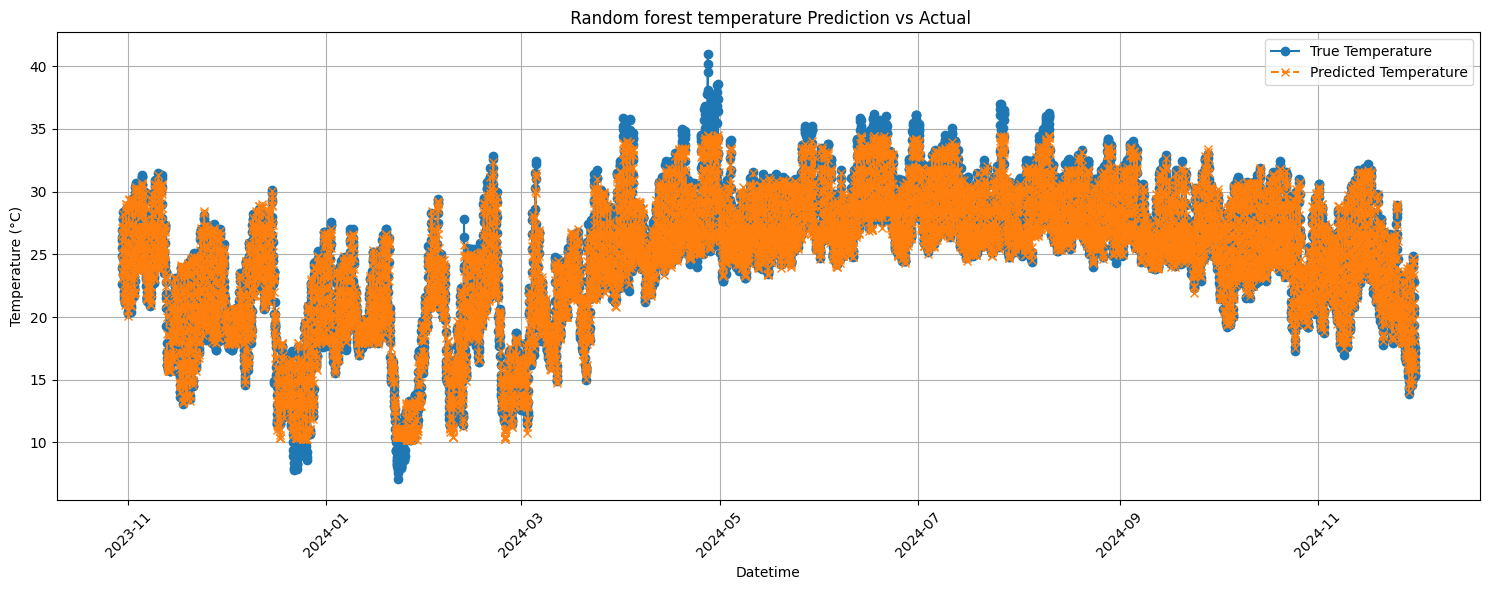

In [14]:
#
results = predictions.select("datetime", "label", "prediction").orderBy("datetime").toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
plt.plot(results["datetime"], results["label"], label="True Temperature", marker='o', linestyle='-')
plt.plot(results["datetime"], results["prediction"], label="Predicted Temperature", marker='x', linestyle='--')
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title(" Random forest temperature Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


24/12/12 16:13:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:13:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:13:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:13:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:13:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:13:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/tmp/ipyke

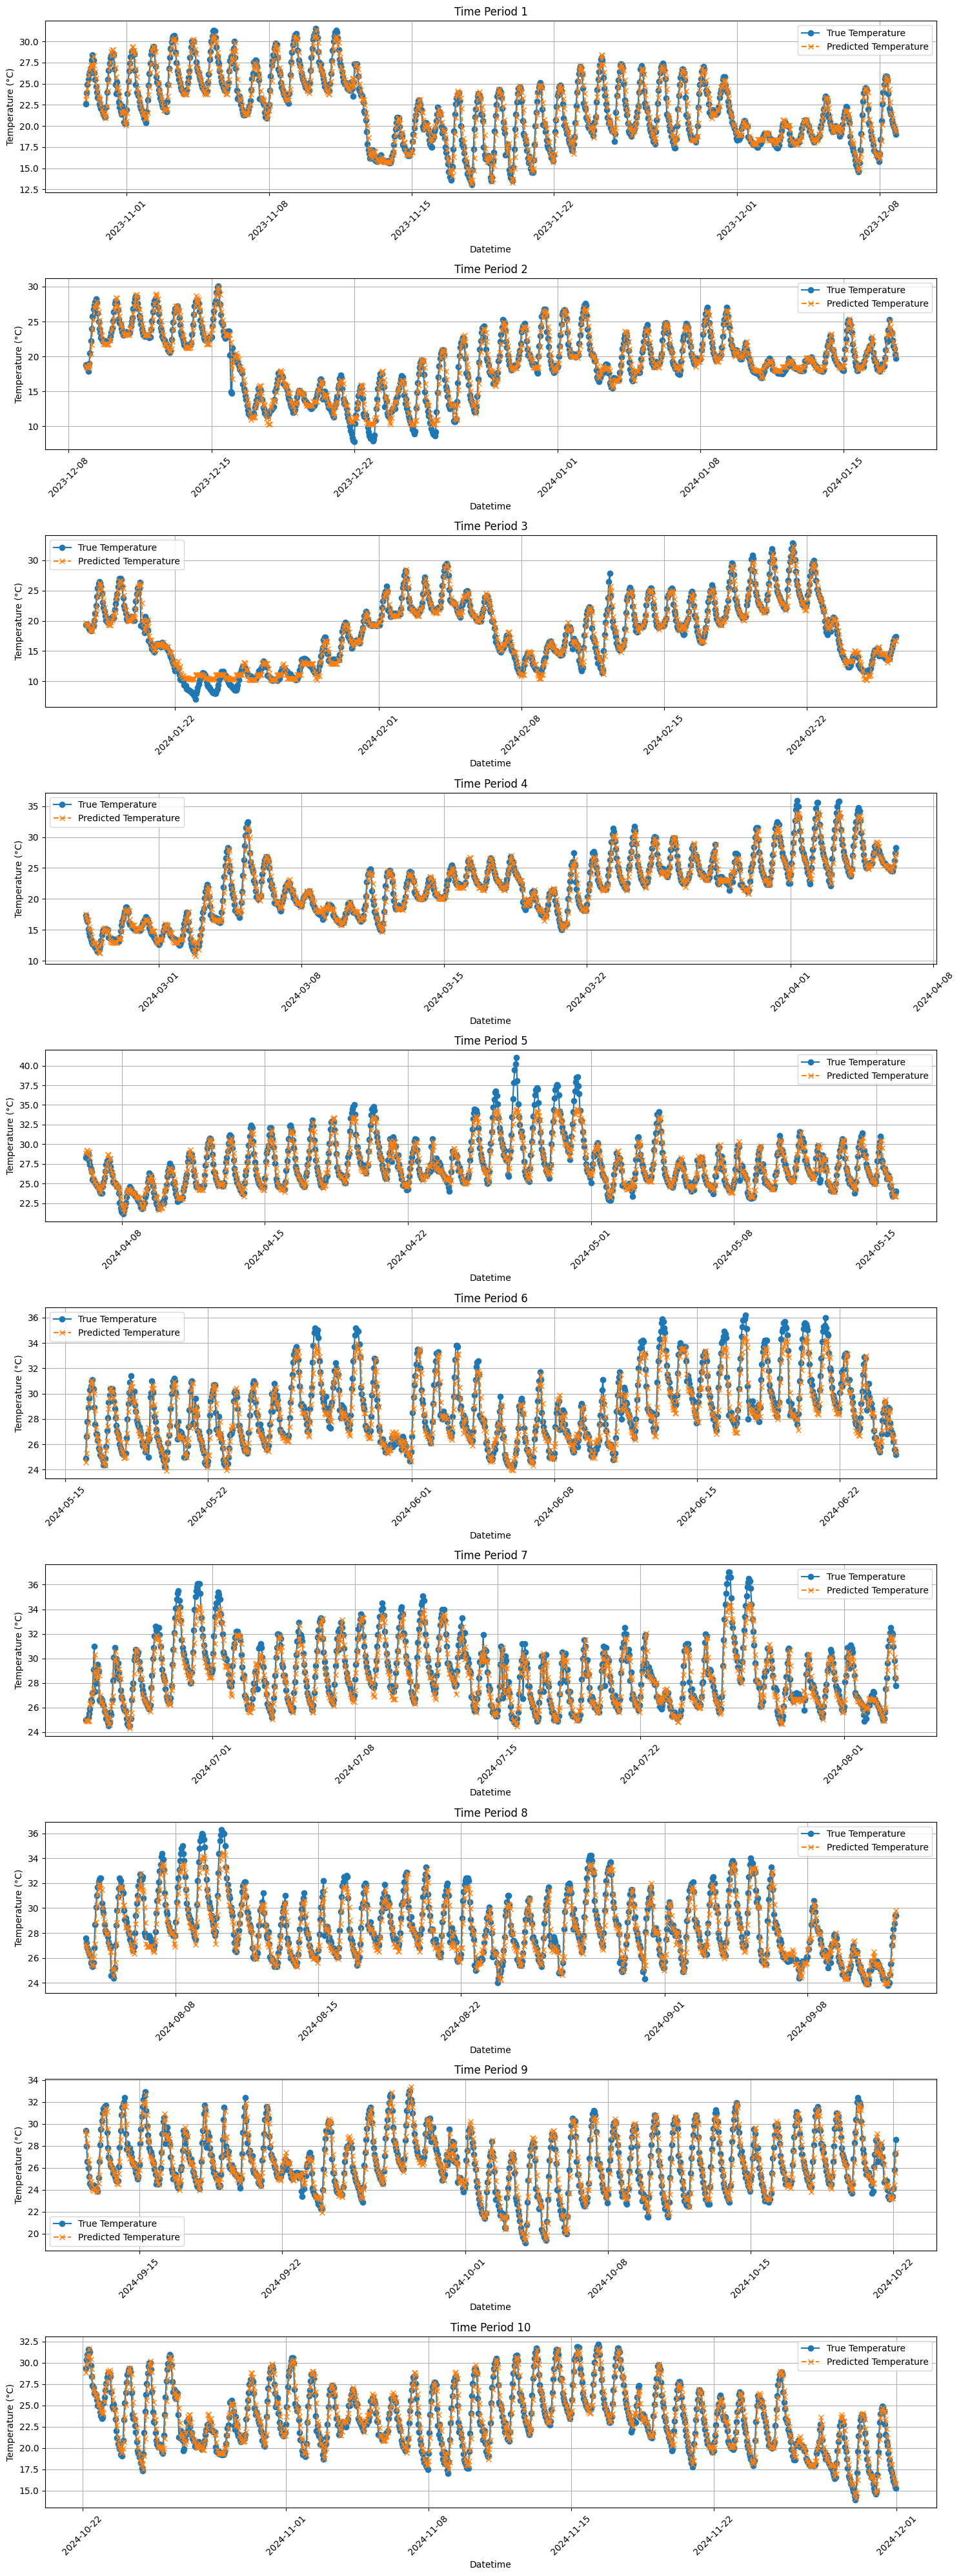

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

results = predictions.select("datetime", "label", "prediction").orderBy("datetime").toPandas()

results['datetime'] = pd.to_datetime(results['datetime'])

# Chia datetime thành 10 khoảng đều nhau
time_bins = pd.cut(results['datetime'], bins=10)

# Vẽ biểu đồ cho mỗi khoảng
plt.figure(figsize=(15, 40))  

for i, (time_bin, group) in enumerate(results.groupby(time_bins)):
    plt.subplot(10, 1, i+1)  # 10 hàng
    plt.plot(group['datetime'], group['label'], label="True Temperature", marker='o', linestyle='-')
    plt.plot(group['datetime'], group['prediction'], label="Predicted Temperature", marker='x', linestyle='--')
    plt.xlabel("Datetime")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Time Period {i+1}")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


24/12/12 16:10:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 1

Random Forest RMSE on test data = 0.8959073895038024


24/12/12 16:10:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 1

Gradient Boosted Tree RMSE on test data = 0.6302898596285474
Model Comparison: Random Forest RMSE = 0.8959073895038024, GBT RMSE = 0.6302898596285474


24/12/12 16:10:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:10:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


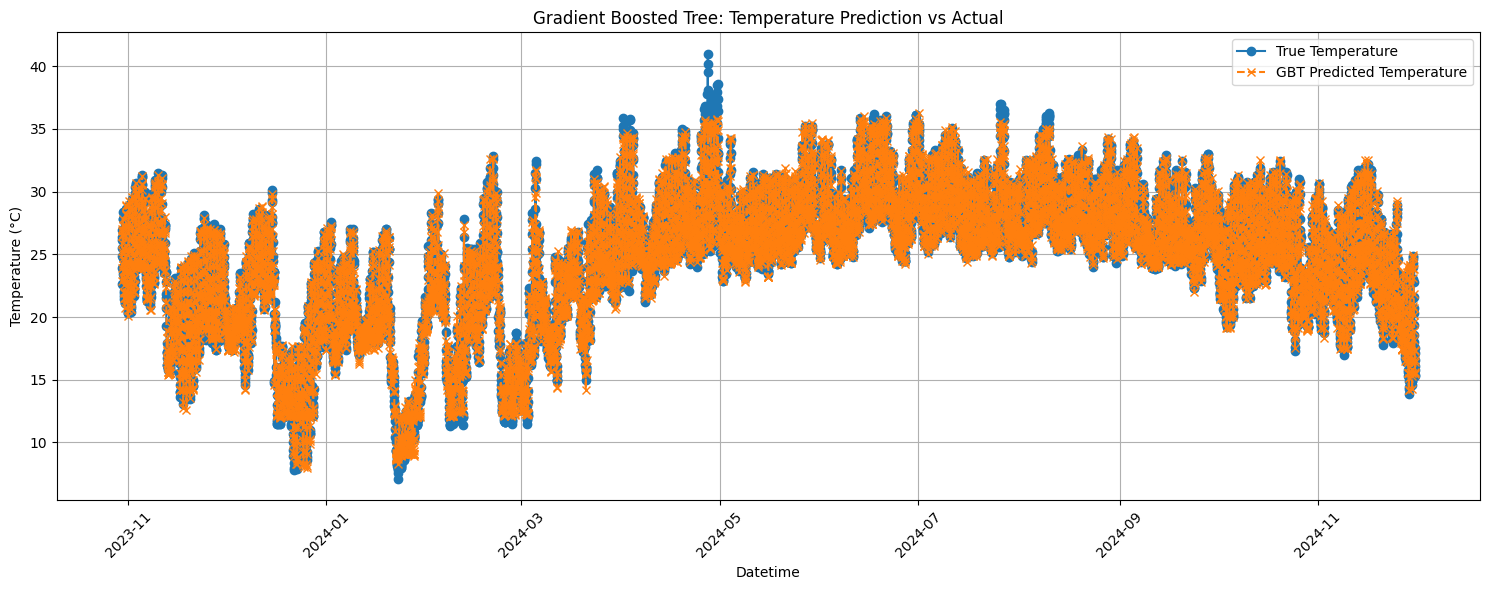

In [15]:
from pyspark.ml.regression import GBTRegressor

#
rf = RandomForestRegressor(featuresCol="features", labelCol="label", maxDepth=5, numTrees=50)
rf_model = rf.fit(train_data)

#
rf_predictions = rf_model.transform(test_data)

# Random Forest
rf_rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE on test data = {rf_rmse}")
#
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxDepth=5, maxIter=50)
gbt_model = gbt.fit(train_data)
#
# Dự đoán trên tập test bằng Gradient Boosted Tree
gbt_predictions = gbt_model.transform(test_data)

# Gradient Boosted Tree
gbt_rmse = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosted Tree RMSE on test data = {gbt_rmse}")

# So sánh kết quả
print(f"Model Comparison: Random Forest RMSE = {rf_rmse}, GBT RMSE = {gbt_rmse}")

# GBT
gbt_results = gbt_predictions.select("datetime", "label", "prediction").orderBy("datetime").toPandas()

# Vẽ biểu đồ GBT
plt.figure(figsize=(15, 6))
plt.plot(gbt_results["datetime"], gbt_results["label"], label="True Temperature", marker='o', linestyle='-')
plt.plot(gbt_results["datetime"], gbt_results["prediction"], label="GBT Predicted Temperature", marker='x', linestyle='--')
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title("Gradient Boosted Tree: Temperature Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


24/12/12 16:16:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:16:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:16:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:16:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:16:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 16:16:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/tmp/ipyke

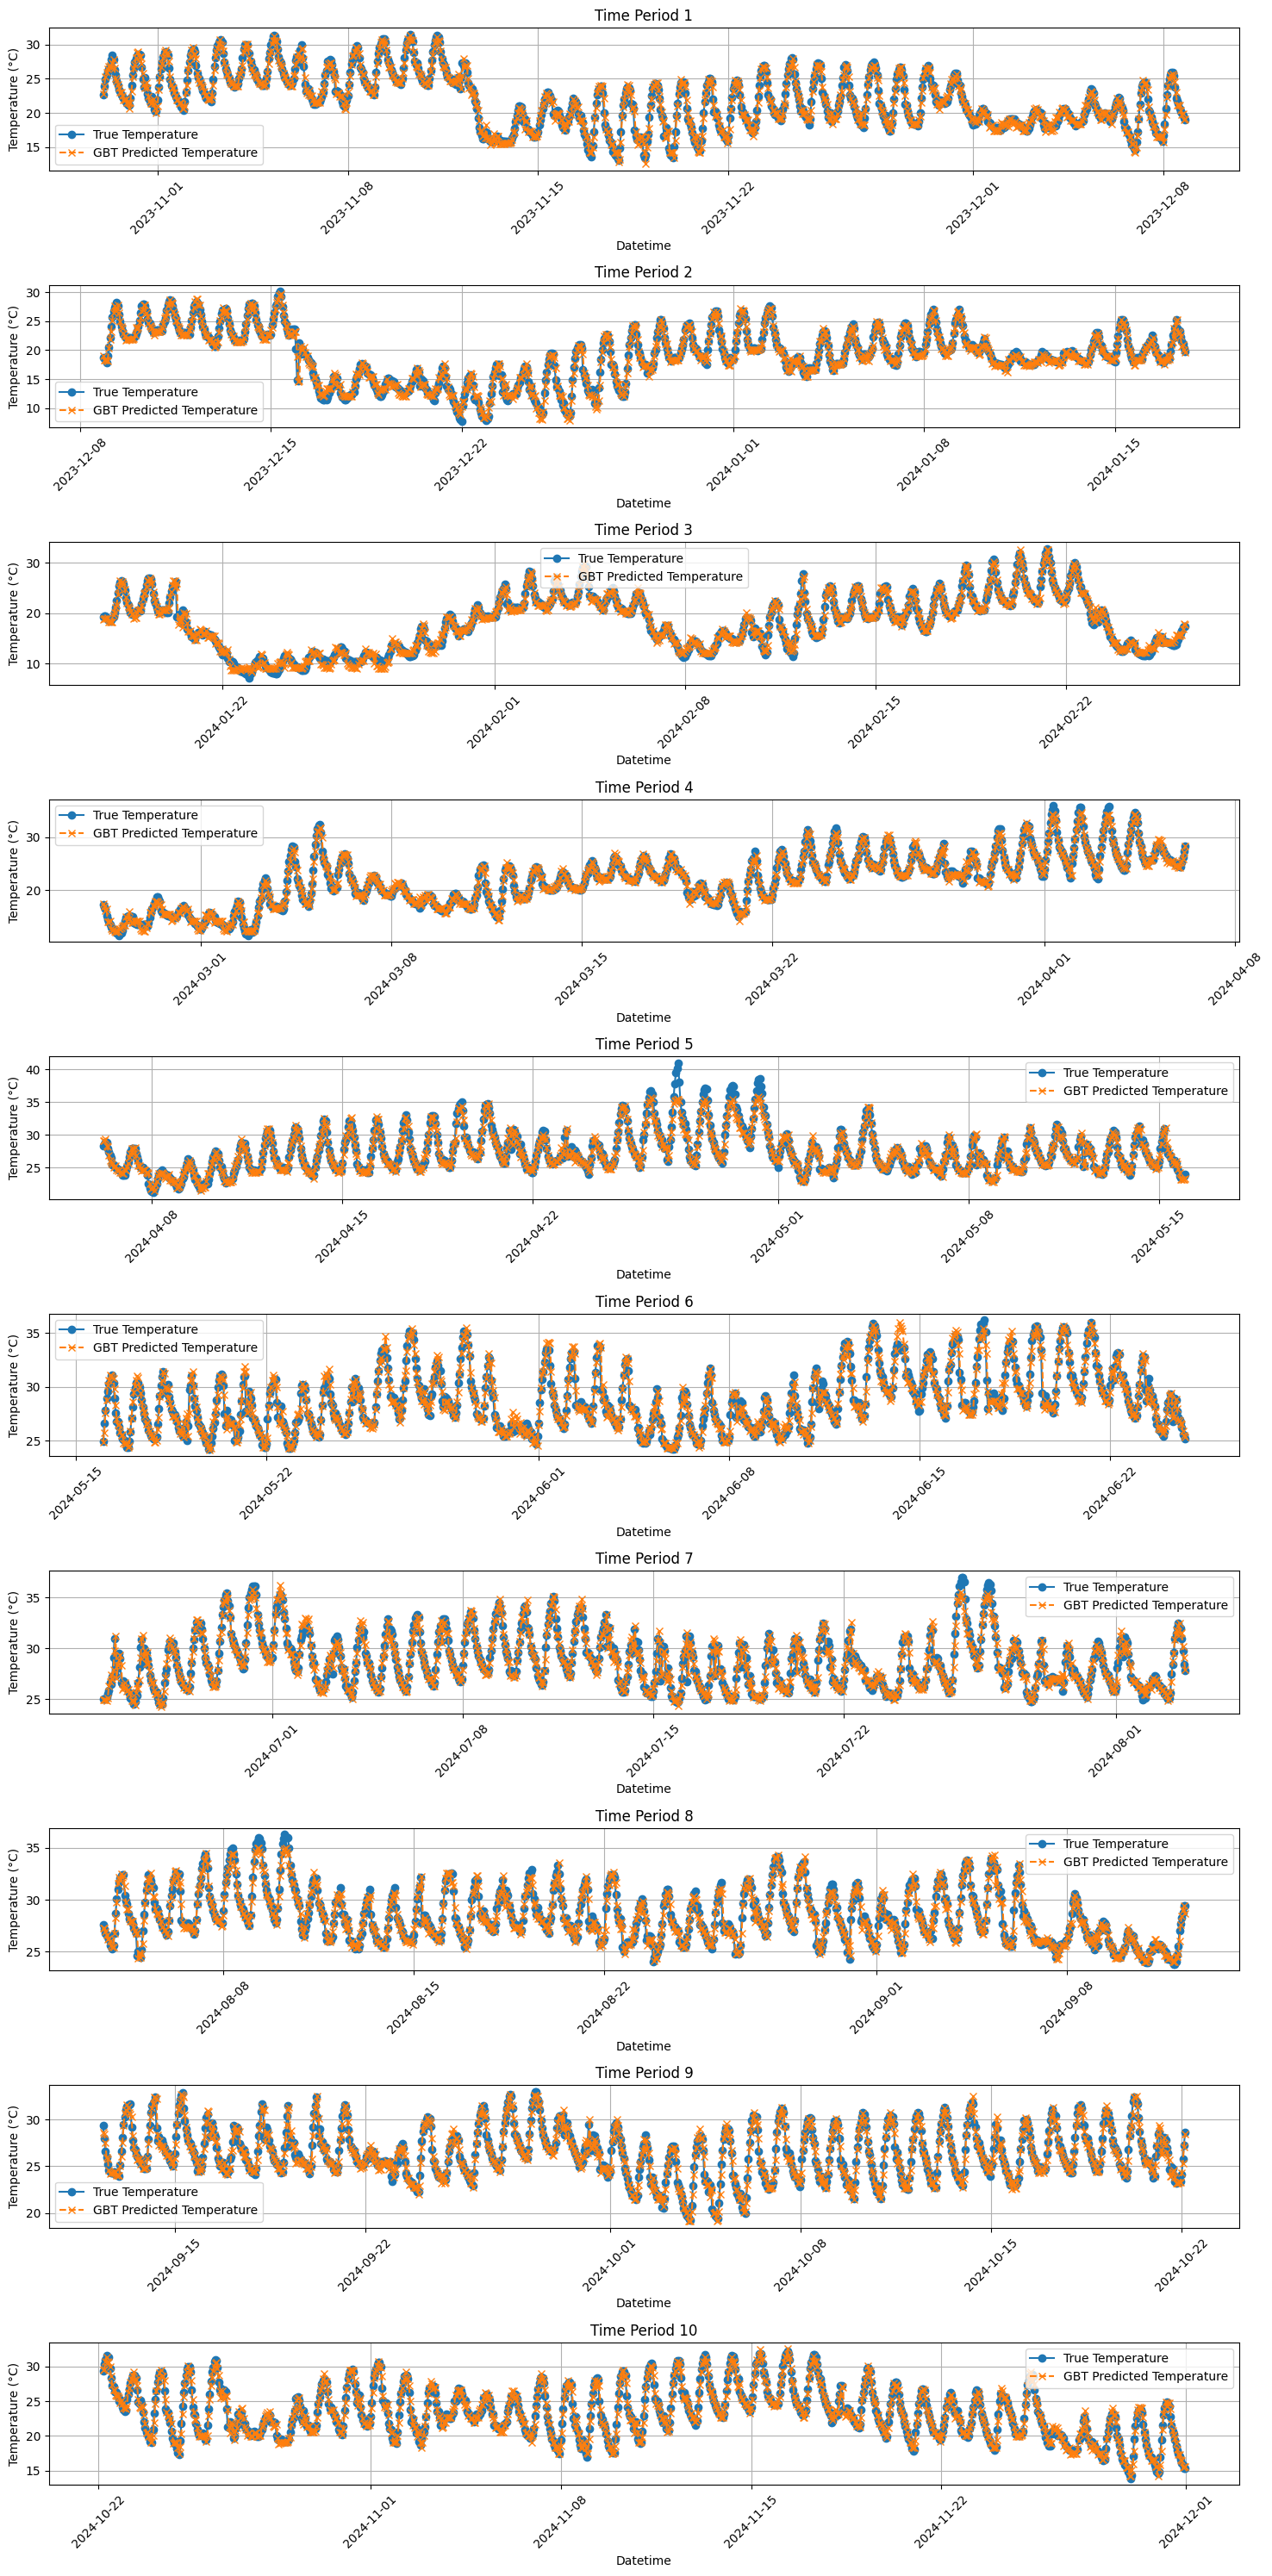

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

gbt_results = gbt_predictions.select("datetime", "label", "prediction").orderBy("datetime").toPandas()

gbt_results['datetime'] = pd.to_datetime(gbt_results['datetime'])

time_bins = pd.cut(gbt_results['datetime'], bins=10)

# Vẽ biểu đồ cho mỗi khoảng
plt.figure(figsize=(50, 30))  

for i, (time_bin, group) in enumerate(gbt_results.groupby(time_bins)):
    plt.subplot(10, 1, i+1) 
    plt.plot(group['datetime'], group['label'], label="True Temperature", marker='o', linestyle='-')
    plt.plot(group['datetime'], group['prediction'], label="GBT Predicted Temperature", marker='x', linestyle='--')
    plt.xlabel("Datetime")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Time Period {i+1}")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
